In [239]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [240]:
#import dataframe
df_ch = pd.read_csv("company_hierarchy.csv")
df_ch.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [241]:
#import second dataframe
df_e = pd.read_csv("employee.csv")
df_e.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [242]:
df_ch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10000 non-null  int64  
 1   boss_id      9999 non-null   float64
 2   dept         10000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [243]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


both datasets have 1000 entries, and a column labeled employee_id so I'll merge these two datasets to make it easier to handle. Also, all column types are what I want them to be so no need to make any changes there. 

In [244]:
#join the two datasets on employee_id
df=pd.merge(left=df_ch, right=df_e, how='left', on='employee_id')
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361.0,sales,0,213000.0,Bachelor,M,5
1,104708,29733.0,HR,0,79000.0,Bachelor,F,3
2,120853,41991.0,sales,0,199000.0,High_School,M,5
3,142630,171266.0,HR,0,143000.0,PhD,F,13
4,72711,198240.0,sales,0,235000.0,Master,M,1


In [245]:
#looking at percentages for missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing)

                Total  Percent
boss_id             1   0.0001
employee_id         0   0.0000
dept                0   0.0000
signing_bonus       0   0.0000
salary              0   0.0000
degree_level        0   0.0000
sex                 0   0.0000
yrs_experience      0   0.0000


Only one entry missing from the boss_id. Let's take a look at this to see if it's important

In [246]:
#printing the rows of missing data
missing_data_rows = df[df.isnull().any(axis=1)]
print(missing_data_rows)

      employee_id  boss_id dept  signing_bonus    salary degree_level sex  \
2427        61554      NaN  CEO              1  700000.0          PhD   M   

      yrs_experience  
2427               7  


The one person missing a boss_id is the CEO. This makes sense, since the CEO isn't going to have a boss in this scenario, so his boss_id will be blank. I'm leaving this missing data without making any changes. 

In [247]:
df.describe()

,employee_id,boss_id,signing_bonus,salary,yrs_experience
count,10000.000000,9999.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,103299.980498,0.301400,189111.800000,3.875200
std,57500.488641,57508.798817,0.458889,88973.796898,3.107409
min,40.000000,79.000000,0.000000,60000.000000,1.000000
25%,50574.500000,55883.000000,0.000000,110000.000000,2.000000
50%,99244.500000,102712.000000,0.000000,182000.000000,3.000000
75%,149748.500000,152288.000000,1.000000,255000.000000,5.000000
max,199956.000000,199950.000000,1.000000,700000.000000,34.000000


medium number of years is 3.8, with a standard deviation of 3.8 years, and the max is 34 years. the mean salary is $189,111 with the standard deviation being $88,973. Next I'm going to create a new column that includes each person's level within the company

In [248]:
# Set everyone as "IC" initially
df['level'] = "IC"

In [249]:
# Identify the CEO and update their level
df.loc[df.dept == "CEO", "level"] = "CEO"

In [250]:
# Define company levels order
company_levels = ["CEO", "E", "VP", "D", "MM"]

In [251]:
# First, create a mapping for levels to their respective bosses
for i in range(1, len(company_levels)):
    # Get the employee IDs of the level above
    boss_ids = df.loc[df.level == company_levels[i-1], 'employee_id']
    
    # Update the levels of employees whose boss is at the current boss_id
    df.loc[df.boss_id.isin(boss_ids), 'level'] = company_levels[i]

#Check frequency of each level
print(df['level'].value_counts())

level
IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: count, dtype: int64


Now that we have everyone's level set up, I'm going to find out the number of people that each person manages

In [252]:
df['total_reports'] = 0

In [253]:
def calculate_total_reports(df):
    # dictionary to store the number of direct reports for each employee
    direct_reports = df.groupby('boss_id')['employee_id'].apply(list).to_dict()
    
    # set the total reports for each employee to 0
    total_reports = {employee: 0 for employee in df['employee_id'].unique()}
    
    def count_reports(employee):
        # If the employee already has their total reports calculated, return the value
        if total_reports[employee] > 0:
            return total_reports[employee]
        
        num_reports = len(direct_reports.get(employee, []))
        
        # count the reports of each direct report
        for report in direct_reports.get(employee, []):
            num_reports += count_reports(report)
        
        # Store the total reports count for the employee
        total_reports[employee] = num_reports
        return num_reports

    # Apply the counting function to all employees
    for employee in df['employee_id'].unique():
        count_reports(employee)

    # Update the DataFrame with the total reports for each employee
    df['total_reports'] = df['employee_id'].map(total_reports)
    
    return df

# Calculate the total reports for each employee
df = calculate_total_reports(df)

In [254]:
#going to print the highest number of reports to make sure the CEO is 9999 since everyone else in the company should be working under him
top_employees = df[['employee_id', 'boss_id', 'level', 'total_reports']].sort_values(by='total_reports', ascending=False)

print(top_employees.head())

      employee_id  boss_id level  total_reports
2427        61554      NaN   CEO           9999
1310        11277  61554.0     E           3598
2778        51535  61554.0     E           2695
1009       110464  61554.0     E           2009
9640        93708  61554.0     E           1693


In [255]:
#setting up color palette
custom_colors = cm.coolwarm(np.linspace(0, 1, len(counts)))
#custom_colors = plt.cm.coolwarm
color_list = custom_colors.tolist()

<Axes: title={'center': 'Salary Based on Dept and Sex'}, xlabel='dept', ylabel='salary'>

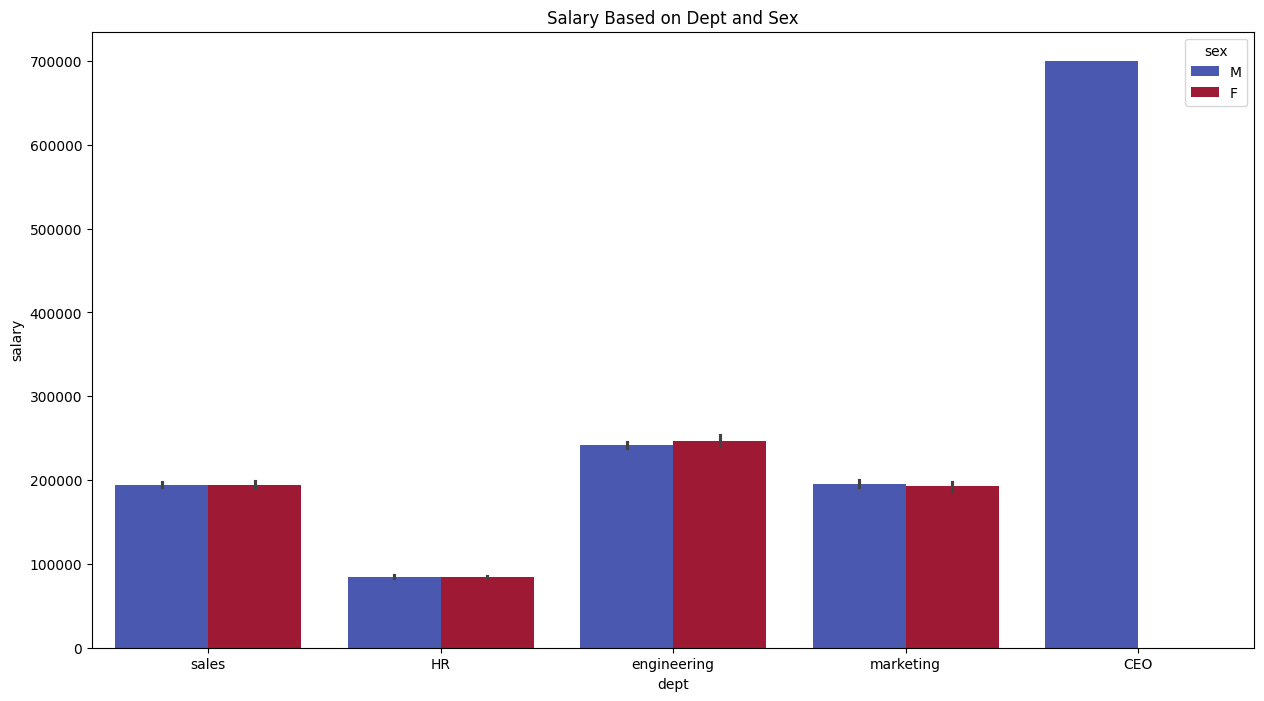

In [256]:
#graph looking at salary, sex, and dept

plt.figure(figsize=(15,8))
plt.title("Salary Based on Dept and Sex")
sns.barplot(x='dept', y='salary', hue='sex', data=df, palette=color_list)

From this graph we see that females make roughly the same amount as males, generally. There is a slight increase in engineering and a slight decrease in marketing, but this graph doesn't compare years of service. 

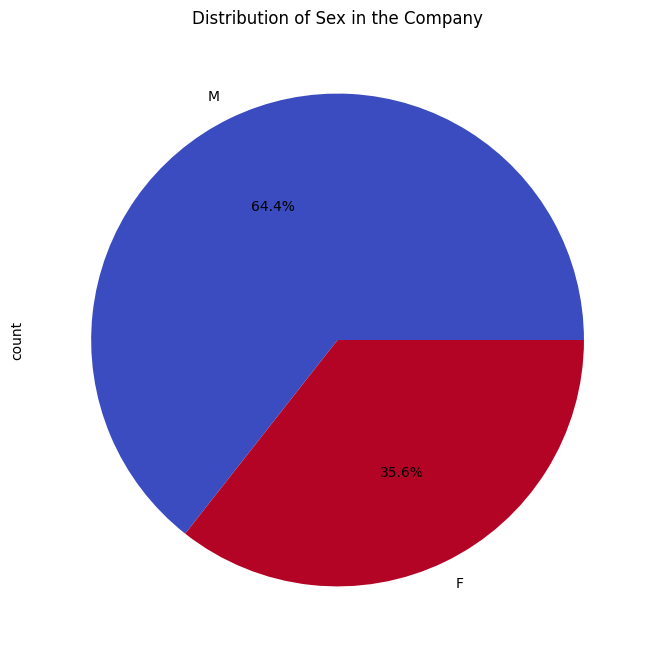

In [257]:
# Count the number of females versus males
counts = df['sex'].value_counts()

# Create the pie chart
plt.figure(figsize=(15,8))
plt.title("Distribution of Sex in the Company")
counts.plot.pie(autopct='%1.1f%%', colors= color_list)
plt.show()

From this pie chart we can clearly see that there are many more males versus femaels in the company overall

<Axes: title={'center': 'Salary based on education level and sex'}, xlabel='degree_level', ylabel='salary'>

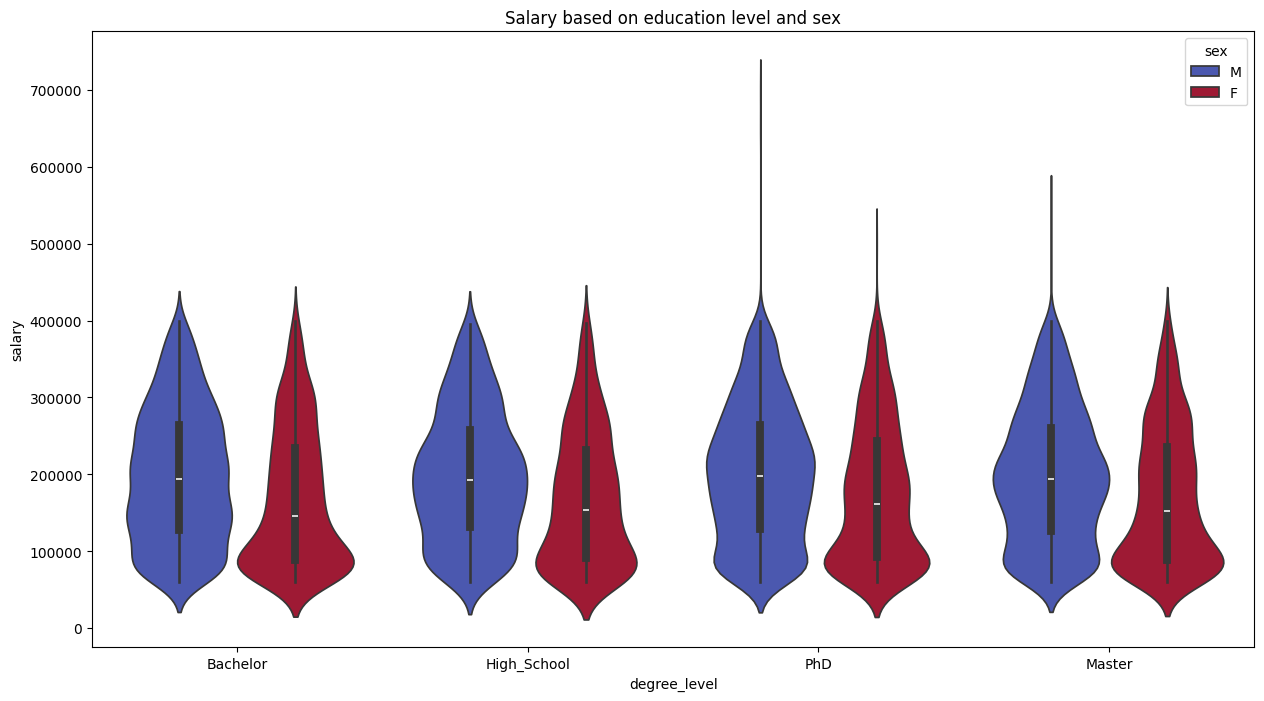

In [258]:
plt.figure(figsize=(15,8))
plt.title("Salary based on education level and sex")
sns.violinplot(x ="degree_level", y ="salary", data = df, hue = 'sex', palette=color_list)

according to this graph, women with the same degree as men, are getting paid less, but this still doesn't take into account the department or years of experience

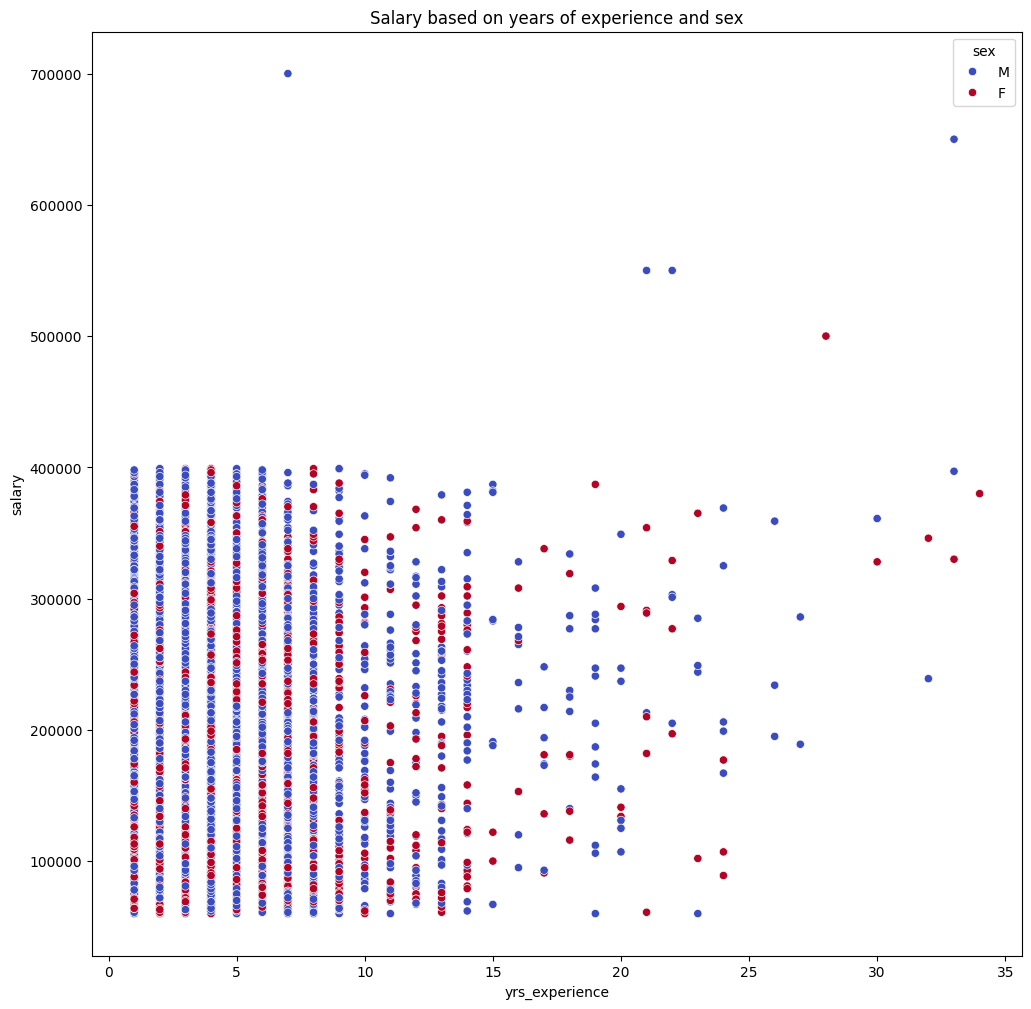

In [259]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='yrs_experience', y='salary', hue='sex', data=df, palette=color_list)
plt.title("Salary based on years of experience and sex")
plt.show()

This graph does appear to show that males are paid more than women, when compared to experience levels so we'll need to look into this further

In [260]:
#making a copy for changes
df2 = df

In [268]:
print(df['dept'].unique())

['sales' 'HR' 'engineering' 'marketing' 'CEO']


In [269]:
# Define mapping dictionaries
degree_mapping = {"High_School": 1, "Bachelor": 2, "Master": 3, "PhD": 4}
level_mapping = {"IC": 1, "MM": 2, "D": 3, "VP": 4, "E": 5, "CEO": 6}
dept_mapping = {"sales": 1, "HR": 2, "engineering": 3, "marketing": 4, "CEO": 5}

In [271]:
# Apply mappings using .replace() and explicitly cast to integer after applying `infer_objects()`
df2['degree_level'] = df2['degree_level'].replace(degree_mapping).infer_objects().astype(int)
df2['level'] = df2['level'].replace(level_mapping).infer_objects().astype(int)
df2['dept'] = df2['dept'].replace(dept_mapping).infer_objects().astype(int)

C:\Users\brean\AppData\Local\Temp\ipykernel_22268\2782774932.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['dept'] = df2['dept'].replace(dept_mapping).infer_objects().astype(int)


In [272]:
# Convert 'sex' to a numerical feature using np.where
df2['sex'] = (df2['sex'] == 'M').astype(int) 

# Display the first few rows of the modified DataFrame
print(df.head())

   employee_id   boss_id  dept  signing_bonus    salary  degree_level  sex  \
0        46456  175361.0     1              0  213000.0             2    0   
1       104708   29733.0     2              0   79000.0             2    0   
2       120853   41991.0     1              0  199000.0             1    0   
3       142630  171266.0     2              0  143000.0             4    0   
4        72711  198240.0     1              0  235000.0             3    0   

   yrs_experience  level  total_reports  
0               5      1              0  
1               3      1              0  
2               5      1              0  
3              13      2             16  
4               1      1              0  


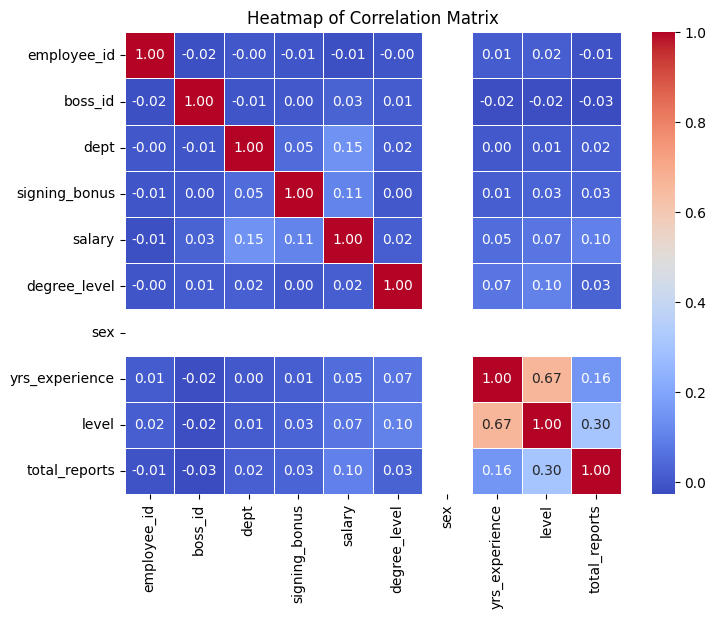

In [273]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title('Heatmap of Correlation Matrix')
plt.show()

created a heatmap to see if there are any obvious correlations between the salary and the other factors but there does appear to be a correlation between years of experience and their level so that does make sense. 

<Axes: >

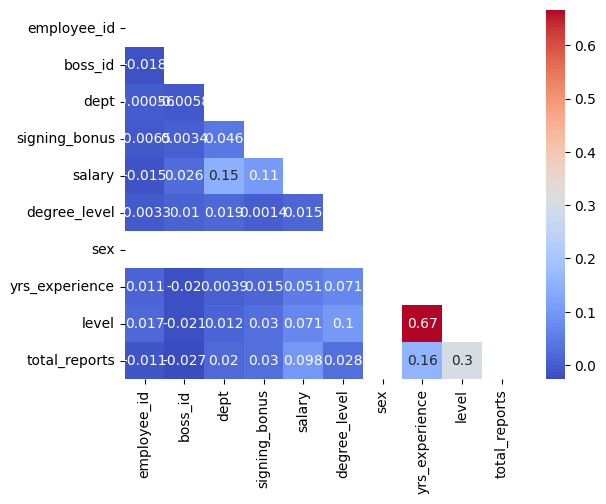

In [217]:
#setting the target and feature variables
x = df.drop(['salary'], axis = 1)
y = df['salary']

In [218]:
#train/test split with 30/70 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [222]:
# Preprocessing for categorical columns (one-hot encoding for 'department', 'education_level', 'gender')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['dept', 'degree_level', 'sex']),
        ('num', 'passthrough', ['yrs_experience', 'signing_bonus'])
    ])

In [223]:
# Create a pipeline that first preprocesses the data, then applies Linear Regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [224]:
# Train the model
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['dept', 'degree_level',
                                                   'sex']),
                                                 ('num', 'passthrough',
                                                  ['yrs_experience',
                                                   'signing_bonus'])])),
                ('regressor', LinearRegression())])

In [225]:
# Make predictions
y_pred = model_pipeline.predict(x_test)

In [226]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5142351027.050667


In [227]:
# You can also check for other metrics like R-squared
r2 = model_pipeline.score(x_test, y_test)
print(f'R-squared: {r2}')

R-squared: 0.341154520738418


In [ ]:
# Predict salary for a new employee
new_employee = pd.DataFrame({
    'department': ['IT'],
    'years_of_experience': [6],
    'education_level': ['Master\'s'],
    'gender': ['Male'],
    'age': [32]
})

predicted_salary = model_pipeline.predict(new_employee)
print(f'Predicted Salary for new employee: {predicted_salary[0]}')